In [1]:
import laspy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric

import src.visualization.clouds

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport src.visualization.clouds
%aimport src.clouds

In [4]:
las = laspy.read("../../data/interim/trees/birch_09.las")
rgb = np.transpose(np.stack([las.red, las.green, las.blue])) / 255
data = torch_geometric.data.Data(
    pos=torch.from_numpy(src.clouds.recenter_cloud(las.xyz)),
    x=torch.from_numpy(rgb),
)

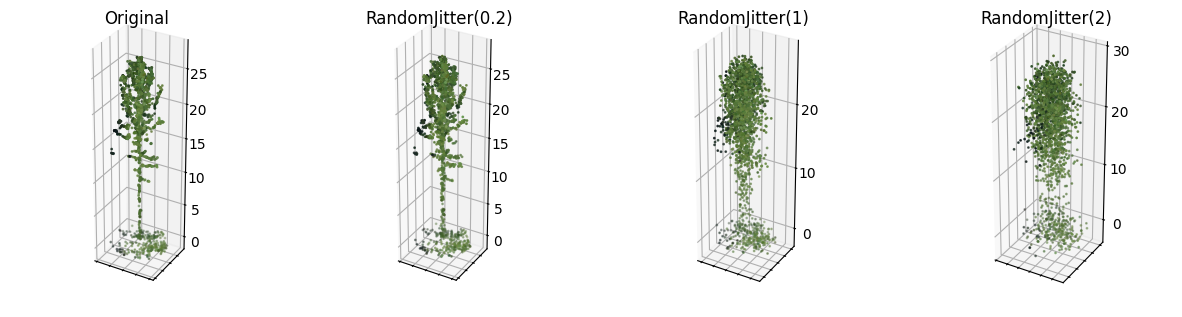

In [5]:
#| include: true
#| label: fig-random-jitter-effect
#| fig-cap: Visualization of the random jitter augmentation on a single birch tree.

fig = plt.figure(figsize=(15, 10))

params = [
    0,
    0.2,
    1,
    2,
]

for i, x in enumerate(params, start=1):
    ax = fig.add_subplot(1, len(params), i, projection="3d")
    transformed = torch_geometric.transforms.RandomJitter(x)(data)
    ax = src.visualization.clouds.scatter_point_cloud_3d(
        xyz=transformed.pos.numpy(),
        color=rgb,
        ax=ax,
    )
    if i == 1:
        ax.set_title("Original")
    else:
        ax.set_title(f"RandomJitter({x})")
    ax.set_aspect("equal")
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

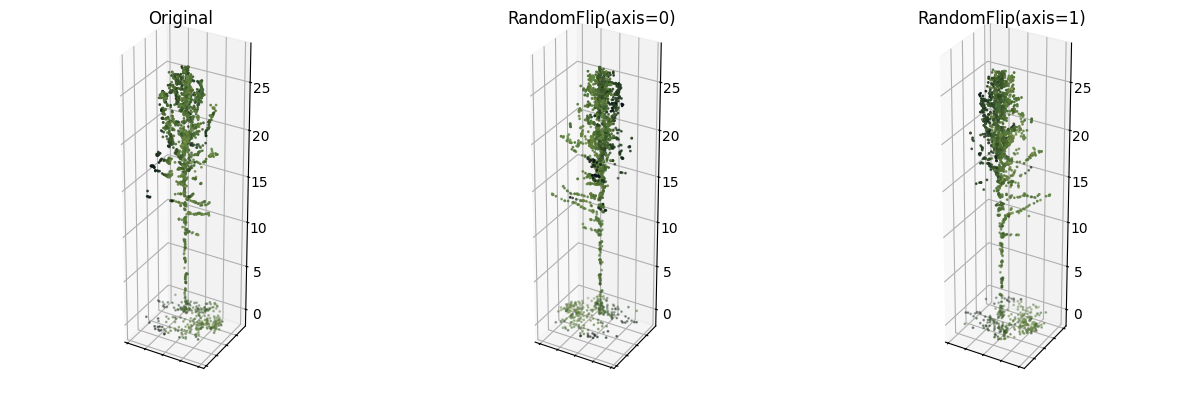

In [6]:
#| include: true
#| label: fig-random-flip-effect
#| fig-cap: |
#|   Visualization of the random flip augmentation on a single birch tree. The effect is
#|   forced for visualization purposes, during training it occurs with a set probability.

fig = plt.figure(figsize=(15, 10))

params = [
    {"axis": 0, "p": 0},
    {"axis": 0, "p": 1},
    {"axis": 1, "p": 1},
]

for i, x in enumerate(params, start=1):
    ax = fig.add_subplot(1, len(params), i, projection="3d")
    transformed = torch_geometric.transforms.RandomFlip(**x)(data)
    ax = src.visualization.clouds.scatter_point_cloud_3d(
        xyz=transformed.pos.numpy(),
        color=rgb,
        ax=ax,
    )
    if i == 1:
        ax.set_title("Original")
    else:
        ax.set_title(f"RandomFlip(axis={x['axis']})")
    ax.set_aspect("equal")
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

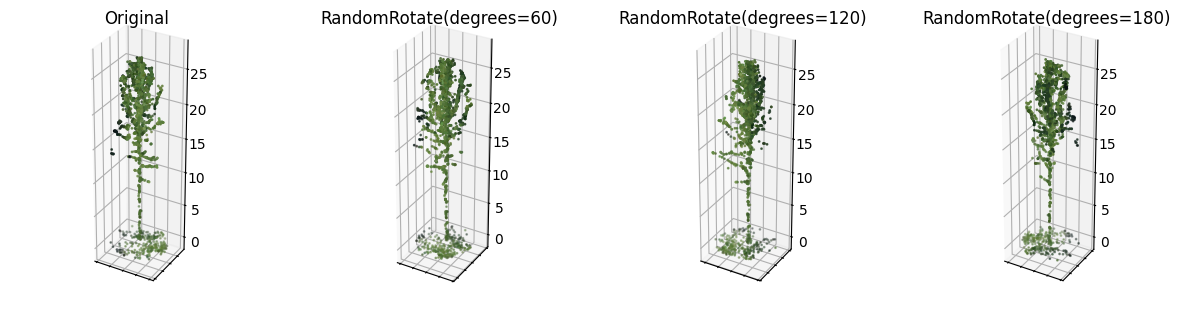

In [7]:
#| include: true
#| label: fig-random-rotate-effect
#| fig-cap: |
#|   Visualization of the random rotation around Z axis augmentation on a single birch
#|   tree. The effect is forced to happen with full amplitude for visualization purposes,
#|   during training a rotation angle is uniformly sampled from a set range.

fig = plt.figure(figsize=(15, 10))

params = [
    (0, 0),
    (60, 60),
    (120, 120),
    (180, 180),
]

for i, x in enumerate(params, start=1):
    ax = fig.add_subplot(1, len(params), i, projection="3d")
    transformed = torch_geometric.transforms.RandomRotate(x, axis=2)(data)
    ax = src.visualization.clouds.scatter_point_cloud_3d(
        xyz=transformed.pos.numpy(),
        color=rgb,
        ax=ax,
    )
    if i == 1:
        ax.set_title("Original")
    else:
        ax.set_title(f"RandomRotate(degrees={x[0]})")
    ax.set_aspect("equal")
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

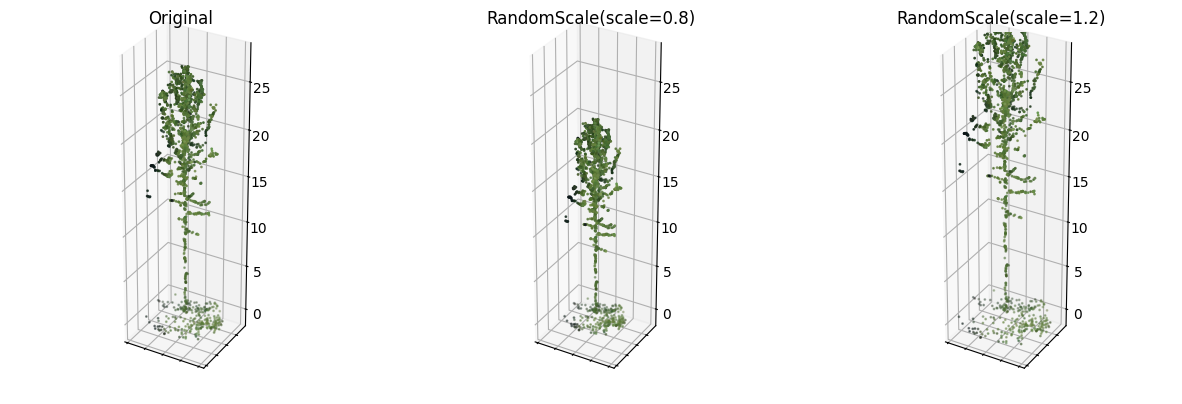

In [8]:
#| include: true
#| label: fig-random-scale-effect
#| fig-cap: |
#|   Visualization of the random scale augmentation on a single birch tree.
#|   The effect is forced to happen with full amplitude for visualization purposes,
#|   during training a scale factor is uniformly sampled from a set range.

fig = plt.figure(figsize=(15, 10))

params = [
    (1, 1),
    (0.8, 0.8),
    (1.2, 1.2),
]

for i, x in enumerate(params, start=1):
    ax = fig.add_subplot(1, len(params), i, projection="3d")
    transformed = torch_geometric.transforms.RandomScale(x)(data)
    ax = src.visualization.clouds.scatter_point_cloud_3d(
        xyz=transformed.pos.numpy(),
        color=rgb,
        ax=ax,
    )
    if i == 1:
        ax.set_title("Original")
        xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    else:
        ax.set_title(f"RandomScale(scale={x[0]})")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
    ax.set_aspect("equal")
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())